In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import json

sys.path.append('ibmHearingAid/multi_gpu')
import pitchnet_evaluate_best
import functions_graph_assembly as fga

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util

import importlib
%matplotlib inline
import matplotlib.pyplot as plt

ImportError in `dataset_util.py` No module named 'pyfftw'


In [6]:
output_directory = '/saved_models/arch_0628/PND_v04_TLAS_classification2'
config_fn = os.path.join(output_directory, 'config.json')
validation_metrics_fn = os.path.join(output_directory, 'validation_metrics.json')

tfrecords_regex = '/om/user/msaddler/data_pitchnet/bernox2005/FixedFilter_f0min100_f0max300/cf100_species002_spont070/*.tfrecords'

with open(config_fn) as f: CONFIG = json.load(f)

ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(validation_metrics_fn,
                                                             metric_key='f0_label:accuracy',
                                                             maximize=True,
                                                             checkpoint_number_key='step')


Selecting checkpoint 62000 (f0_label:accuracy=0.20715387165546417)


In [7]:
ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
batch_size = 128
bytesList_decoding_dict = {"meanrates": {"dtype": "tf.float32", "shape": [100, 500]}}
feature_parsing_dict = pitchnet_evaluate_best.get_feature_parsing_dict_from_tfrecords(tfrecords_regex,
                                                                                      bytesList_decoding_dict)

ITERATOR_PARAMS['feature_parsing_dict'] = feature_parsing_dict
N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']


tf.reset_default_graph()

# BUILD TFRECORDS ITERATOR GRAPH
iterator, dataset, _ = fga.build_tfrecords_iterator(tfrecords_regex,
                                                    num_epochs=1, shuffle_flag=False,
                                                    batch_size=batch_size,
                                                    iterator_type='one-shot',
                                                    **ITERATOR_PARAMS)
input_tensor_dict = iterator.get_next()

### BUILD BRAIN NETWORK GRAPH
batch_subbands = input_tensor_dict[ITERATOR_PARAMS['feature_signal_path']]
while len(batch_subbands.shape) < 4: batch_subbands = tf.expand_dims(batch_subbands, axis=-1)
batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)

### START SESSION AND INITIALIZE GRAPH
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess = tf.Session()
sess.run(init_op)

### BUILD SAVER GRAPH TO LOAD CHECKPOINT
brain_var_scope = 'brain_network'
brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
restore_model_path = os.path.join(output_directory, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
brain_variables =  brain_globals + brain_locals
saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
    sess, brain_variables, output_directory,
    restore_model_path=restore_model_path,
    ckpt_prefix_name=brain_ckpt_prefix_name)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
phase_mode dict_keys(['int64List'])
delta_f0 dict_keys(['floatList'])
f0_lognormal dict_keys(['floatList'])
max_audible_harm dict_keys(['int64List'])
min_audible_harm dict_keys(['int64List'])
f0_label dict_keys(['int64List'])
pin_dBSPL dict_keys(['floatList'])
signal dict_keys(['bytesList'])
Ignoring tfrecords_key `signal` (not found in bytesList_decoding_dict)
f0 dict_keys(['floatList'])
low_harm dict_keys(['int64List'])
f0_log2 dict_keys(['floatList'])
base_f0 dict_keys(['floatList'])
meanrates dict_keys(['bytesList'])
### Files found: 36
/om/user/msaddler/data_pitchnet/bernox2005/FixedFilter_f0min100_f0max300/cf100_species002_spont070/bez2018meanrates_000000-002016.tfrecords 
...
 /om/user/msaddler/data_pitchnet/bernox2005/FixedFilter_f0min100_f0max300/cf100_species002_spont070/bez2018meanrates_070583-072600.tfrecords
Loading brain network config from /saved_models/arch_0628/PND_v04_TLAS_classificat

In [8]:
### EVALUATION ROUTINE + STORE ACTIVATIONS
tensors_to_evaluate = {}

metadata_keys = ['f0', 'f0_label', 'low_harm', 'phase_mode']
for key in metadata_keys:
    tensors_to_evaluate[key] = input_tensor_dict[key]

mean_axis = [1, 2]
for key in brain_container.keys():
    if 'relu' in key:
        activations = brain_container[key]
        if len(activations.shape) == 4:
            tensors_to_evaluate[key] = tf.reduce_mean(activations, axis=mean_axis)
        else:
            tensors_to_evaluate[key] = activations

output_dict = {}
for key in tensors_to_evaluate.keys():
    output_dict[key] = []

display_step = 100
batch_count = 0
try:
    while True:
        evaluated_batch = sess.run(tensors_to_evaluate)
        for key in set(output_dict.keys()).intersection(evaluated_batch.keys()):
            key_val = np.array(evaluated_batch[key]).tolist()
            if not isinstance(key_val, list): key_val = [key_val]
            output_dict[key].extend(key_val)
            
        batch_count += 1
        if batch_count % display_step == 0: print(batch_count)
except tf.errors.OutOfRangeError:
    print('End of evaluation dataset reached.')

for key in output_dict.keys():
    output_dict[key] = np.array(output_dict[key])
    print(key, output_dict[key].shape)


100
200
300
400
500
End of evaluation dataset reached.
phase_mode (72600,)
relu_0 (72600, 16)
relu_1 (72600, 32)
relu_2 (72600, 256)
f0 (72600,)
low_harm (72600,)
relu_3 (72600, 128)
relu_fc_intermediate (72600, 256)
relu_4 (72600, 256)
f0_label (72600,)
relu_5 (72600, 512)


In [9]:
mask = output_dict['phase_mode'] == 0
for key in output_dict.keys():
    output_dict[key] = output_dict[key][mask]

sort_idx = np.argsort(output_dict['f0'])
for key in output_dict.keys():
    output_dict[key] = output_dict[key][sort_idx]
    print(key, output_dict[key].shape)


phase_mode (36300,)
relu_0 (36300, 16)
relu_1 (36300, 32)
relu_2 (36300, 256)
f0 (36300,)
low_harm (36300,)
relu_3 (36300, 128)
relu_fc_intermediate (36300, 256)
relu_4 (36300, 256)
f0_label (36300,)
relu_5 (36300, 512)


In [14]:
def compute_tuning_tensor(output_dict,
                          key_act='relu_1',
                          key_x='low_harm',
                          key_y='f0_label_coarse'):
    
    x_unique = np.unique(output_dict[key_x])
    y_unique = np.unique(output_dict[key_y])
    shape = [x_unique.shape[0], y_unique.shape[0], output_dict[key_act].shape[1]]
    dtype = output_dict[key_act].dtype
    tuning_tensor = np.zeros(shape, dtype=dtype)
    tuning_tensor_counts = np.zeros(shape[:-1] + [1], dtype=int)
    
    x_value_indexes = np.digitize(output_dict[key_x], x_unique, right=True)
    y_value_indexes = np.digitize(output_dict[key_y], y_unique, right=True)
    for idx in range(output_dict[key_act].shape[0]):
        x_idx = x_value_indexes[idx]
        y_idx = y_value_indexes[idx]
        act = output_dict[key_act][idx]
        
        tuning_tensor[x_idx, y_idx, :] += act
        tuning_tensor_counts[x_idx, y_idx] += 1
    
    tuning_tensor = tuning_tensor / tuning_tensor_counts
    return tuning_tensor


coarse_f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3, binwidth_in_octaves=1/24)
output_dict['f0']
output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'], coarse_f0_bins)

tuning_tensor = compute_tuning_tensor(output_dict, key_act='relu_3')
print('computed tuning_tensor:', tuning_tensor.shape)

f0_tuning_array = np.mean(tuning_tensor, axis=0)
print('computed f0_tuning_array:', f0_tuning_array.shape)

low_harm_tuning_array = np.mean(tuning_tensor, axis=1)
print('computed low_harm_tuning_array:', low_harm_tuning_array.shape)

sort_idx_f0_tuning = np.argsort(np.argmax(f0_tuning_array, axis=0))
sort_idx_low_harm_tuning = np.argsort(np.argmax(low_harm_tuning_array, axis=0))


tuning_tensor = tuning_tensor[:, :, sort_idx_low_harm_tuning]
f0_tuning_array = f0_tuning_array[:, sort_idx_low_harm_tuning]
low_harm_tuning_array = low_harm_tuning_array[:, sort_idx_low_harm_tuning]


computed tuning_tensor: (30, 43, 128)
computed f0_tuning_array: (43, 128)
computed low_harm_tuning_array: (30, 128)


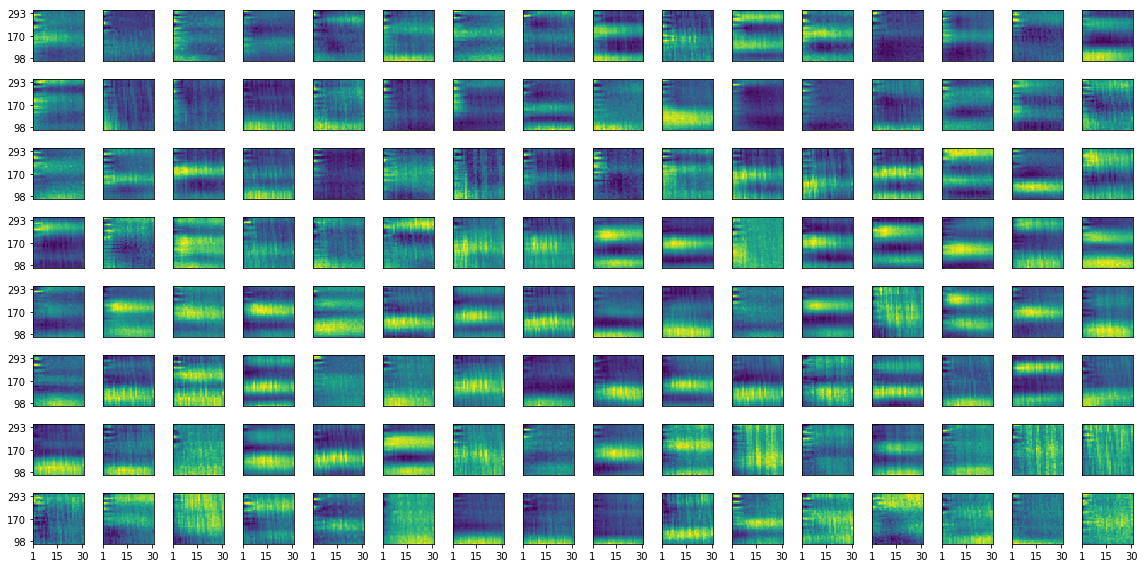

In [15]:
f0_bin_values = [coarse_f0_bins[idx] for idx in np.unique(output_dict['f0_label_coarse'])]
f0_bin_values = np.array(f0_bin_values)
f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=3, dtype=int)
f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

low_harm_values = np.unique(output_dict['low_harm'])
low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=3, dtype=int)
low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

N = tuning_tensor.shape[-1]

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    Z = tuning_tensor[:, :, idx].T
    ax[idx].imshow(Z, origin='lower', aspect='auto', extent=[0, Z.shape[1], 0, Z.shape[0]])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    if idx % NCOLS == 0:
        ax[idx].set_yticks(f0_idx)
        ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(low_harm_idx)
        ax[idx].set_xticklabels(low_harm_labels)

plt.tight_layout()
plt.show()

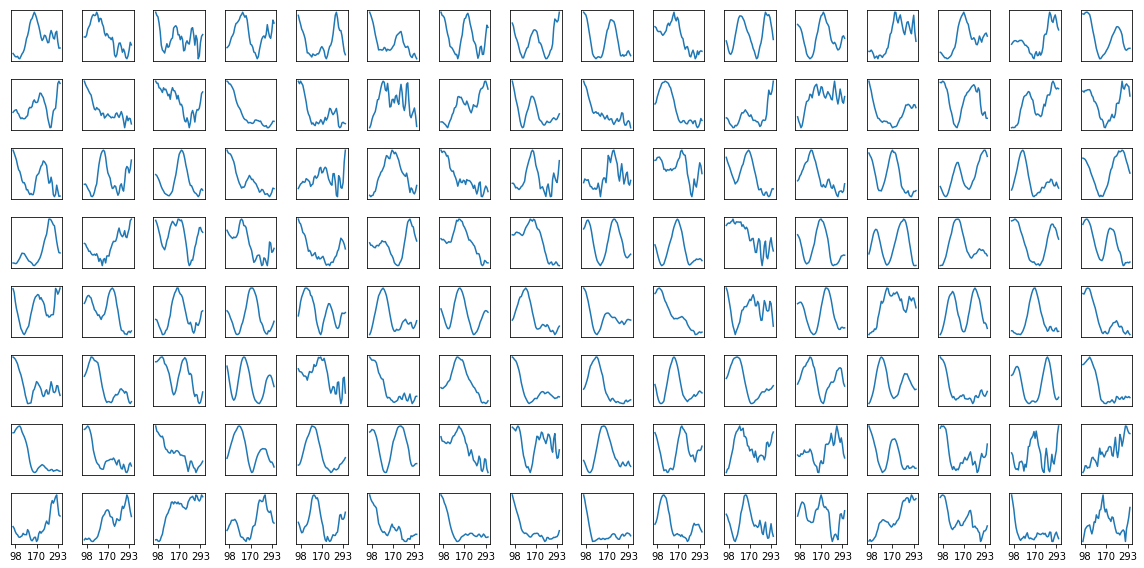

In [16]:
f0_bin_values = [coarse_f0_bins[idx] for idx in np.unique(output_dict['f0_label_coarse'])]
f0_bin_values = np.array(f0_bin_values)
f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=3, dtype=int)
f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

N = f0_tuning_array.shape[-1]

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    Z = tuning_tensor[:, :, idx].T
    ax[idx].plot(np.arange(0, f0_tuning_array.shape[0]), f0_tuning_array[:, idx])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
#     if idx % NCOLS == 0:
#         ax[idx].set_yticks(f0_idx)
#         ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(f0_idx)
        ax[idx].set_xticklabels(f0_labels)

plt.tight_layout()
plt.show()

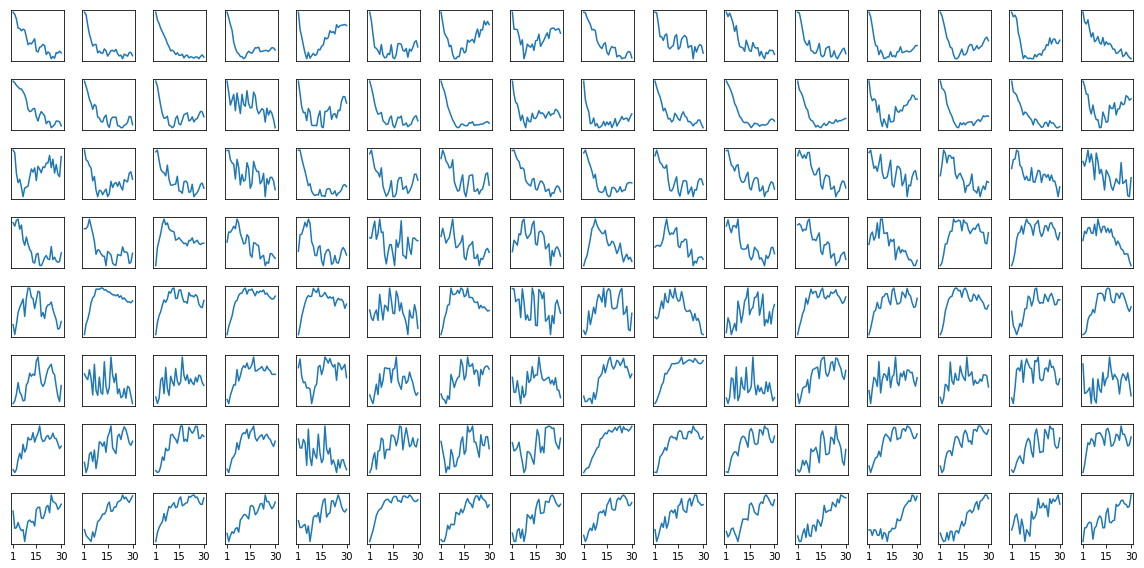

In [17]:
low_harm_values = np.unique(output_dict['low_harm'])
low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=3, dtype=int)
low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

N = low_harm_tuning_array.shape[-1]

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    Z = tuning_tensor[:, :, idx].T
    ax[idx].plot(np.arange(0, low_harm_tuning_array.shape[0]), low_harm_tuning_array[:, idx])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
#     if idx % NCOLS == 0:
#         ax[idx].set_yticks(f0_idx)
#         ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(low_harm_idx)
        ax[idx].set_xticklabels(low_harm_labels)

plt.tight_layout()
plt.show()

In [83]:
def get_octave_bins(octave_min=-2.0,
                    octave_max=2.0,
                    num_bins=4*12*16+1):
    return np.linspace(octave_min, octave_max, num_bins)


def compute_octave_tuning_array(output_dict,
                                key_act='relu_5',
                                kwargs_f0_bins={},
                                kwargs_octave_bins={},
                                shuffle=False):
    ### Compute generic tuning tensor (low_harm and f0 tuning)
    coarse_f0_bins = dataset_util.get_f0_bins(**kwargs_f0_bins)
    output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'],
                                                              coarse_f0_bins)
    tuning_tensor = compute_tuning_tensor(output_dict,
                                          key_act=key_act,
                                          key_x='low_harm',
                                          key_y='f0_label_coarse')
    ### Collapse tuning tensor along low_harm axis to get f0 tuning
    f0_tuning_array = np.mean(tuning_tensor, axis=0)
    sort_idx_f0_tuning = np.argsort(np.argmax(f0_tuning_array, axis=0))
    tuning_tensor = tuning_tensor[:, :, sort_idx_f0_tuning]
    f0_tuning_array = f0_tuning_array[:, sort_idx_f0_tuning]
    f0_bin_values = np.array([coarse_f0_bins[idx]
                              for idx in np.unique(output_dict['f0_label_coarse'])])
    
    ### If specified, shuffle the f0 axis to get null distribution
    if shuffle:
        indexes = np.arange(0, f0_tuning_array.shape[0])
        np.random.shuffle(indexes)
        f0_tuning_array = f0_tuning_array[indexes]
    
    ### Compute best f0s and setup octave tuning array
    best_f0s = f0_bin_values[np.argmax(f0_tuning_array, axis=0)]
    octave_bins = get_octave_bins(**kwargs_octave_bins)
    octave_tuning_array = -1 * np.ones([octave_bins.shape[0], f0_tuning_array.shape[1]])
    
    ### Populate octave tuning array
    for itr1 in range(f0_tuning_array.shape[1]):
        best_f0 = best_f0s[itr1]
        f0_tuning = f0_tuning_array[:, itr1]
        octaves_re_best_f0 = np.log2(f0_bin_values / best_f0)
        octave_indexes = np.digitize(octaves_re_best_f0, octave_bins)
        values = np.zeros_like(octave_bins)
        counts = np.zeros_like(octave_bins)
        for itr0, oct_idx in enumerate(octave_indexes):
            values[oct_idx] += f0_tuning_array[itr0, itr1]
            counts[oct_idx] += 1
        valid_indexes = counts > 0
        octave_tuning_array[valid_indexes, itr1] = values[valid_indexes] / counts[valid_indexes]

    return octave_bins, octave_tuning_array


kwargs_octave_bins = {
    'octave_min': -2,
    'octave_max': 2,
    'num_bins': 12*4+1,
}
octave_bins, octave_tuning_array = compute_octave_tuning_array(output_dict,
                                                               key_act='relu_5',
                                                               kwargs_octave_bins=kwargs_octave_bins,
                                                               shuffle=False)


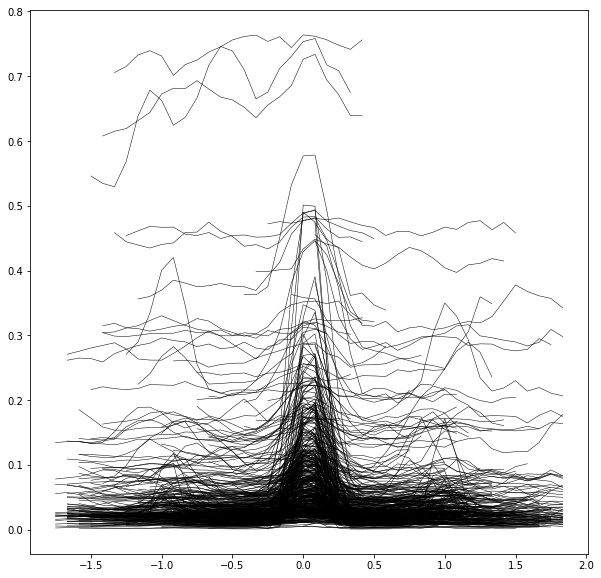

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

plot_kwargs = {
    'lw': 0.5,
    'color': 'k'
}

N = octave_tuning_array.shape[-1]
for itr1 in range(N):
    
    tuning_curve = octave_tuning_array[:, itr1]
    valid_idx = tuning_curve > 0
    y = tuning_curve[valid_idx]
    x = octave_bins[valid_idx]
    ax.plot(x, y, **plot_kwargs)
